In [40]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, make_scorer, f1_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as  sns
plt.style.use('ggplot')
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

In [2]:
train = pd.read_csv('./data/train.csv', index_col='id')
test = pd.read_csv('./data/test.csv', index_col='id')

In [3]:
genetic_selected_names = ['ptt_min','inr_max','calcium_min.1','temperature_mean','glucose_min','glucose_mean','weight_admit','aniongap_max','aniongap_min','potassium_min.1','bicarbonate_max.1','chloride_max.1','gcs_verbal','hemoglobin_min.1','hematocrit_min.1','bun_max','gcs_eyes','resp_rate_max','resp_rate_min','spo2_mean','spo2_min','dbp_min','sbp_mean','sbp_min','heart_rate_max','heart_rate_mean','race','admission_age']
genetic_selected_names.append('aki')
train = train.loc[:, genetic_selected_names]
test = test.loc[:, genetic_selected_names]

## Try

In [11]:
def train_model(df, model):
    y = df['aki'].astype(float)
    X = df.drop(['aki'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))
    return model

In [5]:
model = RandomForestClassifier()
train_model(train, model)


Accuracy: 0.4806201550387597
              precision    recall  f1-score   support

         0.0       0.52      0.70      0.60      3157
         1.0       0.33      0.04      0.07      1904
         2.0       0.44      0.60      0.51      3059
         3.0       0.52      0.34      0.41      1555

    accuracy                           0.48      9675
   macro avg       0.45      0.42      0.40      9675
weighted avg       0.46      0.48      0.44      9675



In [20]:
def search_hyperparameter_RandomForest(train, test, data_name='', param_dist=None):
    y = train['aki'].astype(float)
    X = train.drop(['aki'], axis=1)

    if param_dist is None:
        param_dist = {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 5, 10, 15],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["auto", "sqrt", "log2"],
            "class_weight": [None, "balanced"]
        }

    model = RandomForestClassifier()

    random_search = RandomizedSearchCV(model, param_distributions=param_dist, scoring='accuracy', cv=5, n_iter=10, random_state=20, n_jobs=-1, verbose=2)
    random_search.fit(X, y)

    params = random_search.cv_results_['params']
    scores = random_search.cv_results_['mean_test_score']
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(scores)), scores, '-o')
    plt.ylabel('mean_test_score')
    plt.xticks(range(len(scores)), params, rotation=45)
    plt.title(f'{data_name} Randomized Search CV Results')
    plt.tight_layout()
    plt.show()

    print(f'best_params: {random_search.best_params_}')
    print(f'best_score: {random_search.best_score_}')

    best_model = random_search.best_estimator_
    y_test = test['aki'].astype(float)
    X_test = test.drop(['aki'], axis=1)
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{data_name}最优模型在测试集上的表现:")
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


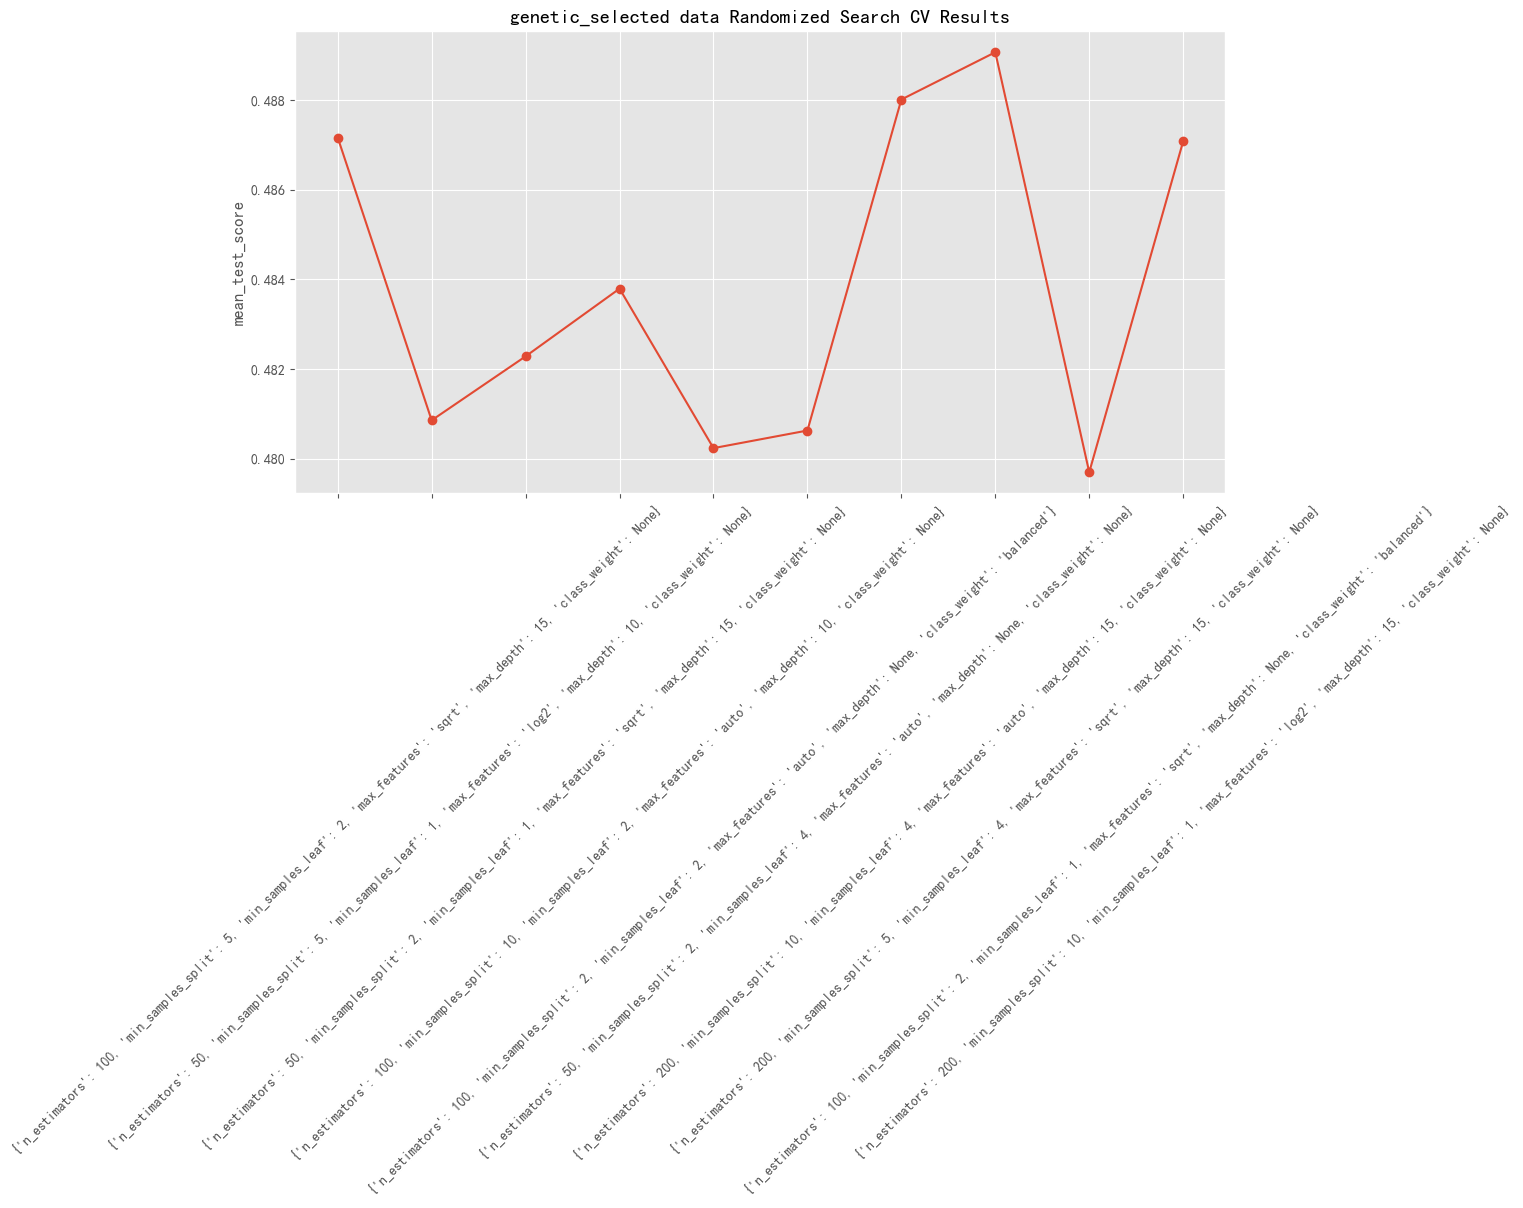

best_params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': None}
best_score: 0.48906449691466347
genetic_selected data最优模型在测试集上的表现:
Accuracy: 0.4791830322073841
              precision    recall  f1-score   support

         0.0       0.51      0.68      0.58       808
         1.0       0.00      0.00      0.00       461
         2.0       0.44      0.61      0.51       837
         3.0       0.55      0.36      0.43       440

    accuracy                           0.48      2546
   macro avg       0.37      0.41      0.38      2546
weighted avg       0.40      0.48      0.43      2546



In [21]:
search_hyperparameter_RandomForest(train, test, "genetic_selected data")

In [14]:
search.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'class_weight': None}

In [15]:
search.best_score_

0.4881962841340891

In [16]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9354005167958657


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      3157
         1.0       1.00      0.89      0.94      1904
         2.0       0.94      0.96      0.95      3059
         3.0       0.96      0.83      0.89      1555

    accuracy                           0.94      9675
   macro avg       0.95      0.92      0.93      9675
weighted avg       0.94      0.94      0.93      9675



In [13]:
model = RandomForestClassifier(n_estimators=200,min_samples_split=10,min_samples_leaf=4,max_features='sqrt',max_depth=None,class_weight=None)
y_train = train['aki'].astype(float)
X_train = train.drop(['aki'], axis=1)
model.fit(X_train, y_train)

y_test = test['aki'].astype(float)
X_test = test.drop(['aki'], axis=1)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('测试集上表现：')
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

测试集上表现：
Accuracy: 0.48036135113904166
              precision    recall  f1-score   support

         0.0       0.51      0.67      0.58       808
         1.0       0.33      0.01      0.02       461
         2.0       0.44      0.61      0.51       837
         3.0       0.55      0.37      0.44       440

    accuracy                           0.48      2546
   macro avg       0.46      0.42      0.39      2546
weighted avg       0.46      0.48      0.43      2546



In [14]:
y_pred

array([0., 3., 0., ..., 1., 2., 2.])

In [16]:
y_pred_proba = model.predict_proba(X_test)
auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print("AUC (Macro):", auc_macro)

AUC (Macro): 0.6906565960058769


## Adjust Parameters

### Draw parameters with the Accurancy 2D curve to select the appropriate interval

In [11]:
y_train = train['aki'].astype(float)
X_train = train.drop(['aki'], axis=1)
y_test = test['aki'].astype(float)
X_test = test.drop(['aki'], axis=1)

def train_rf(X_train, y_train, parameters): 
    rf = RandomForestClassifier(
        n_estimators = parameters['n_estimators'],
        max_leaf_nodes = parameters['max_leaf_nodes'],
        max_depth = parameters['max_depth'],
        min_samples_split = parameters['min_samples_split'],
        min_samples_leaf = parameters['min_samples_leaf'],
        min_weight_fraction_leaf = parameters['min_weight_fraction_leaf'],
        max_features = parameters['max_features'],
        criterion = parameters['criterion'],
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    return accuracy_score(y_test,rf.predict(X_test))

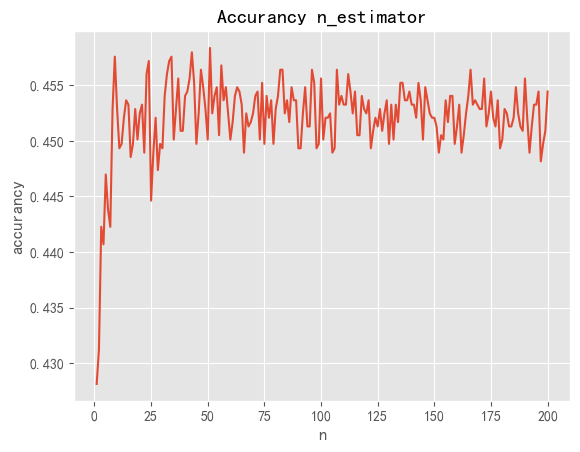

In [29]:
parameters = {       
    'n_estimators':20,
    'max_leaf_nodes':20,
    'max_depth':20,
    'min_samples_split':20,
    'min_samples_leaf':20,
    'min_weight_fraction_leaf':0.03,
    'max_features':30,
    'criterion':'entropy'
}
accurancyList = {
    'params':[],
    'precision':[]
}
for n in range(1,201):
    parameters['n_estimators'] = n
    accurancyList['params'].append(parameters)
    accurancyList['precision'].append(train_rf(X_train, y_train, parameters))

plt.plot(range(1,201),accurancyList['precision'])
plt.xlabel('n')
plt.ylabel('accurancy')
plt.title('Accurancy n_estimator')
plt.show()

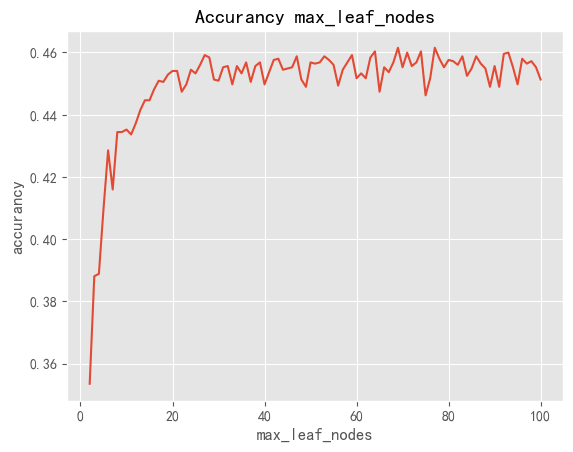

In [31]:
parameters = {       
    'n_estimators':20,
    'max_leaf_nodes':20,
    'max_depth':20,
    'min_samples_split':20,
    'min_samples_leaf':20,
    'min_weight_fraction_leaf':0.03,
    'max_features':30,
    'criterion':'entropy'
}
accurancyList = {
    'params':[],
    'precision':[]
}
for n in range(2,101):
    parameters['max_leaf_nodes'] = n
    accurancyList['params'].append(parameters)
    accurancyList['precision'].append(train_rf(X_train, y_train, parameters))

plt.plot(range(2,101),accurancyList['precision'])
plt.xlabel('max_leaf_nodes')
plt.ylabel('accurancy')
plt.title('Accurancy max_leaf_nodes')
plt.show()

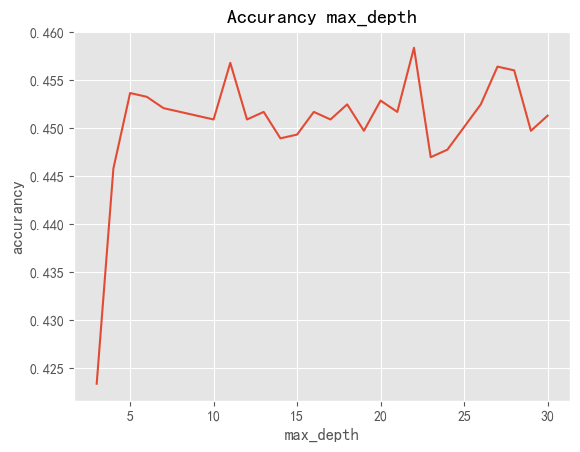

In [30]:
parameters = {       
    'n_estimators':20,
    'max_leaf_nodes':20,
    'max_depth':20,
    'min_samples_split':20,
    'min_samples_leaf':20,
    'min_weight_fraction_leaf':0.03,
    'max_features':30,
    'criterion':'entropy'
}
accurancyList = {
    'params':[],
    'precision':[]
}
for n in range(3,31):
    parameters['max_depth'] = n
    accurancyList['params'].append(parameters)
    accurancyList['precision'].append(train_rf(X_train, y_train, parameters))

plt.plot(range(3,31),accurancyList['precision'])
plt.xlabel('max_depth')
plt.ylabel('accurancy')
plt.title('Accurancy max_depth')
plt.show()

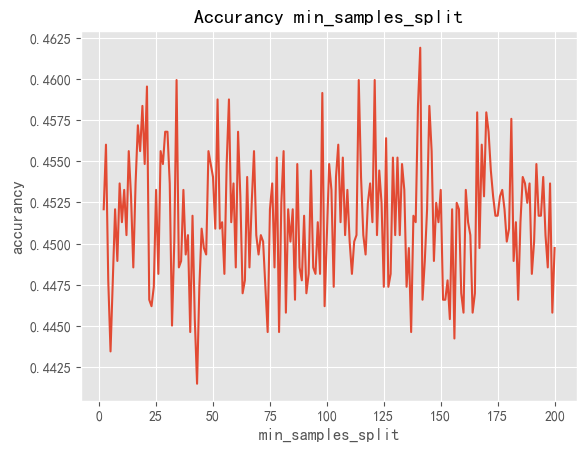

In [5]:
parameters = {       
    'n_estimators':20,
    'max_leaf_nodes':20,
    'max_depth':20,
    'min_samples_split':20,
    'min_samples_leaf':20,
    'min_weight_fraction_leaf':0.03,
    'max_features':30,
    'criterion':'entropy'
}
accurancyList = {
    'params':[],
    'precision':[]
}
for n in range(2,201):
    parameters['min_samples_split'] = n
    accurancyList['params'].append(parameters)
    accurancyList['precision'].append(train_rf(X_train, y_train, parameters))

plt.plot(range(2,201),accurancyList['precision'])
plt.xlabel('min_samples_split')
plt.ylabel('accurancy')
plt.title('Accurancy min_samples_split')
plt.show()

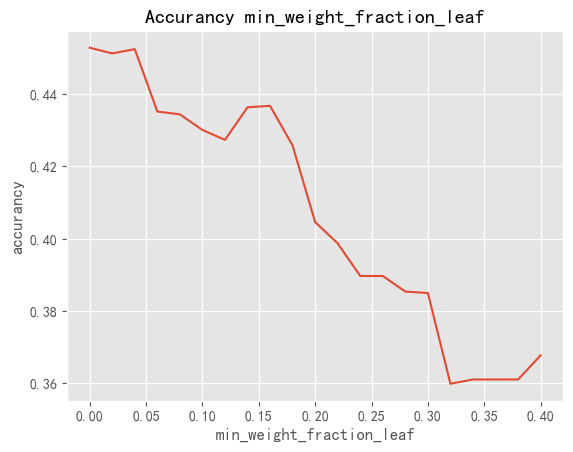

In [6]:
parameters = {       
    'n_estimators':20,
    'max_leaf_nodes':20,
    'max_depth':20,
    'min_samples_split':20,
    'min_samples_leaf':20,
    'min_weight_fraction_leaf':0.03,
    'max_features':30,
    'criterion':'entropy'
}
accurancyList = {
    'params':[],
    'precision':[]
}
for n in np.arange(0, 0.41, 0.02):
    parameters['min_weight_fraction_leaf'] = n
    accurancyList['params'].append(parameters)
    accurancyList['precision'].append(train_rf(X_train, y_train, parameters))

plt.plot(np.arange(0, 0.41, 0.02),accurancyList['precision'])
plt.xlabel('min_weight_fraction_leaf')
plt.ylabel('accurancy')
plt.title('Accurancy min_weight_fraction_leaf')
plt.show()

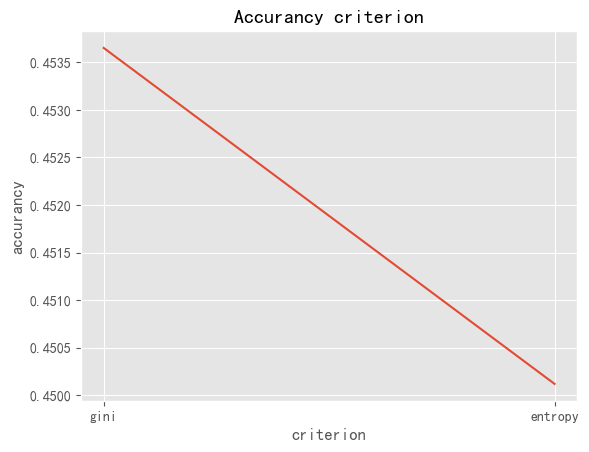

In [7]:
parameters = {       
    'n_estimators':20,
    'max_leaf_nodes':20,
    'max_depth':20,
    'min_samples_split':20,
    'min_samples_leaf':20,
    'min_weight_fraction_leaf':0.03,
    'max_features':30,
    'criterion':'entropy'
}
accurancyList = {
    'params':[],
    'precision':[]
}
for n in ["gini", "entropy"]:
    parameters['criterion'] = n
    accurancyList['params'].append(parameters)
    accurancyList['precision'].append(train_rf(X_train, y_train, parameters))

plt.plot(["gini", "entropy"],accurancyList['precision'])
plt.xlabel('criterion')
plt.ylabel('accurancy')
plt.title('Accurancy criterion')
plt.show()

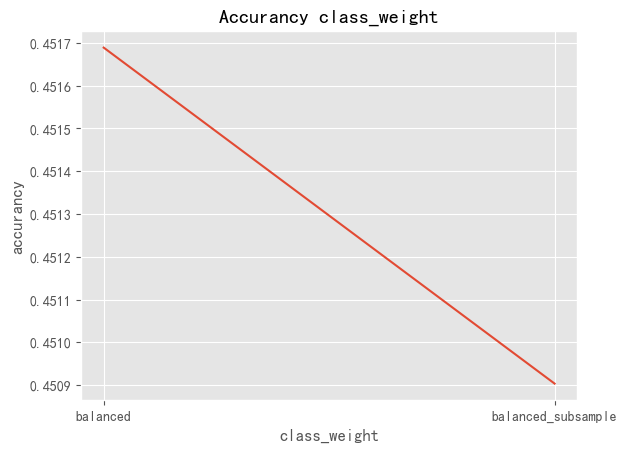

In [13]:
parameters = {       
    'n_estimators':20,
    'max_leaf_nodes':20,
    'max_depth':20,
    'min_samples_split':20,
    'min_samples_leaf':20,
    'min_weight_fraction_leaf':0.03,
    'max_features':30,
    'criterion':'entropy'
}
accurancyList = {
    'params':[],
    'precision':[]
}
for n in ["balanced", "balanced_subsample"]:
    parameters['class_weight'] = n
    accurancyList['params'].append(parameters)
    accurancyList['precision'].append(train_rf(X_train, y_train, parameters))

plt.plot(["balanced", "balanced_subsample"],accurancyList['precision'])
plt.xlabel('class_weight')
plt.ylabel('accurancy')
plt.title('Accurancy class_weight')
plt.show()

### RandomizedSearch

In [14]:
param_dist = {
    "n_estimators": [*range(45,55)],
    "max_leaf_nodes": [*range(70,80)],
    "min_samples_split": [30, 100, 140],
}
model = RandomForestClassifier(max_depth=22, min_weight_fraction_leaf=0.0, criterion="gini", class_weight="balanced", n_jobs=-1, random_state=20)
rs = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring="accuracy", cv=5, n_iter=10)
rs.fit(X_train, y_train)

print("best_params", rs.best_params_)
print("best_score", rs.best_score_)
print('------------------------------------------------------------------')
best_model = rs.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

y_pred_proba = best_model.predict_proba(X_test)
auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print("RandomForest AUC (Macro):", auc_macro)
print(classification_report(y_test, y_pred_test))
print('------------------------------------------------------------------')
print(f'train accuracy: {accuracy_train}, test accuracy: {accuracy_test}')

best_params {'n_estimators': 52, 'min_samples_split': 30, 'max_leaf_nodes': 77}
best_score 0.44292391711393486
------------------------------------------------------------------
RandomForest AUC (Macro): 0.6751873189019824
              precision    recall  f1-score   support

         0.0       0.53      0.57      0.55       808
         1.0       0.22      0.15      0.18       461
         2.0       0.46      0.34      0.39       837
         3.0       0.38      0.64      0.47       440

    accuracy                           0.43      2546
   macro avg       0.40      0.42      0.40      2546
weighted avg       0.42      0.43      0.42      2546

------------------------------------------------------------------
train accuracy: 0.46115681977922024, test accuracy: 0.4300864100549882


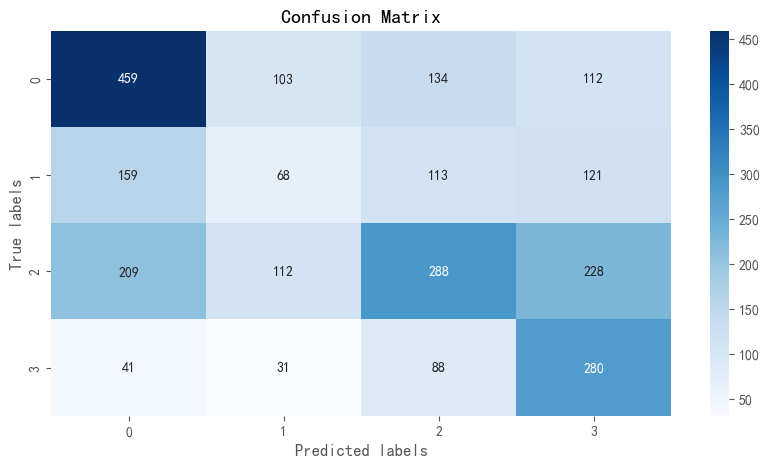

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Sample imbalance problem

### change class_weight

In [5]:
y_train = train['aki'].astype(float)
X_train = train.drop(['aki'], axis=1)
y_test = test['aki'].astype(float)
X_test = test.drop(['aki'], axis=1)

In [19]:
def train_model(train, test, model):
    y = train['aki'].astype(float)
    X = train.drop(['aki'], axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=20)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print("valid accuracy:", accuracy)
    print(classification_report(y_valid, y_pred))

    y_pred_proba = model.predict_proba(X_valid)
    auc_macro = roc_auc_score(y_valid, y_pred_proba, multi_class="ovr", average="macro")
    print("DecisionTree Valid AUC (Macro):", auc_macro)

    print('------------------------------------------------------------------')
    y_test = test['aki'].astype(float)
    X_test = test.drop(['aki'], axis=1)
    best_model = model
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    y_pred_proba = best_model.predict_proba(X_test)
    auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
    print("DecisionTree Test AUC (Macro):", auc_macro)
    print(classification_report(y_test, y_pred_test))
    print('------------------------------------------------------------------')
    print(f'train accuracy: {accuracy_train}, test accuracy: {accuracy_test}')
    return model

In [20]:
model = RandomForestClassifier(
    max_depth=22,
    min_weight_fraction_leaf=0.0,
    criterion="gini",
    class_weight={0: 1,1: 2.5,2: 1,3: 2},
    n_estimators=52,
    max_leaf_nodes=30,
    min_samples_split=77,
    )
train_model(train, test, model)

valid accuracy: 0.321343669250646
              precision    recall  f1-score   support

         0.0       0.70      0.28      0.40      3157
         1.0       0.22      0.78      0.34      1904
         2.0       0.54      0.02      0.03      3059
         3.0       0.43      0.45      0.44      1555

    accuracy                           0.32      9675
   macro avg       0.47      0.38      0.30      9675
weighted avg       0.51      0.32      0.28      9675

DecisionTree Valid AUC (Macro): 0.6911882710908892
------------------------------------------------------------------
DecisionTree Test AUC (Macro): 0.6726514455880305
              precision    recall  f1-score   support

         0.0       0.66      0.23      0.35       808
         1.0       0.20      0.77      0.32       461
         2.0       0.48      0.02      0.04       837
         3.0       0.48      0.49      0.48       440

    accuracy                           0.31      2546
   macro avg       0.46      0.38    

RandomForestClassifier(class_weight={0: 1, 1: 2.5, 2: 1, 3: 2}, max_depth=22,
                       max_leaf_nodes=30, min_samples_split=77,
                       n_estimators=52)

In [21]:
model = RandomForestClassifier(
    max_depth=22,
    min_weight_fraction_leaf=0.0,
    criterion="gini",
    class_weight="balanced",
    n_estimators=52,
    max_leaf_nodes=30,
    min_samples_split=77,
    )
train_model(train, test, model)

valid accuracy: 0.4427906976744186
              precision    recall  f1-score   support

         0.0       0.53      0.63      0.58      3157
         1.0       0.29      0.15      0.20      1904
         2.0       0.47      0.34      0.40      3059
         3.0       0.36      0.60      0.45      1555

    accuracy                           0.44      9675
   macro avg       0.41      0.43      0.41      9675
weighted avg       0.43      0.44      0.43      9675

DecisionTree Valid AUC (Macro): 0.6882771026693205
------------------------------------------------------------------
DecisionTree Test AUC (Macro): 0.6710422043166206
              precision    recall  f1-score   support

         0.0       0.50      0.59      0.54       808
         1.0       0.20      0.10      0.13       461
         2.0       0.47      0.33      0.39       837
         3.0       0.36      0.64      0.46       440

    accuracy                           0.42      2546
   macro avg       0.38      0.41   

RandomForestClassifier(class_weight='balanced', max_depth=22, max_leaf_nodes=30,
                       min_samples_split=77, n_estimators=52)

### Smote

In [22]:
from imblearn.over_sampling import SMOTE

In [23]:
smote = SMOTE(random_state=20)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [25]:
X_train_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)

In [26]:
X_train_resampled.head()

,ptt_min,inr_max,calcium_min.1,temperature_mean,glucose_min,glucose_mean,weight_admit,aniongap_max,aniongap_min,potassium_min.1,bicarbonate_max.1,chloride_max.1,gcs_verbal,hemoglobin_min.1,hematocrit_min.1,bun_max,gcs_eyes,resp_rate_max,resp_rate_min,spo2_mean,spo2_min,dbp_min,sbp_mean,sbp_min,heart_rate_max,heart_rate_mean,race,admission_age,aki
0,28.6,1.1,8.1,36.222000,76.0,146.2,110.0,20.0,15.0,4.8,28.0,101.0,5.0,9.2,27.8,52.0,4.0,24.0,13.0,98.916667,96.0,40.0,116.136364,103.0,104.0,100.083333,7,79.953141,3.0
1,28.4,2.3,7.9,36.558000,127.0,129.5,82.0,22.0,13.0,2.9,29.0,93.0,5.0,12.1,36.3,30.0,4.0,38.0,17.0,95.444444,91.0,56.0,109.833333,97.0,134.0,97.263158,32,78.194169,0.0
2,26.0,1.1,8.7,36.805000,207.0,254.0,62.1,12.0,12.0,3.8,27.0,102.0,5.0,9.5,31.1,8.0,4.0,19.0,14.0,97.166667,94.0,56.0,112.153846,95.0,97.0,84.166667,28,65.602396,2.0
3,26.1,1.2,8.3,37.087143,111.0,117.0,113.1,11.0,10.0,4.3,39.0,93.0,0.0,16.1,56.5,39.0,1.0,31.0,14.0,94.800000,89.0,60.0,138.160000,113.0,87.0,71.461538,27,64.906629,2.0
4,27.7,1.1,7.5,37.158750,158.0,187.0,97.4,16.0,13.0,4.2,22.0,109.0,0.0,14.0,44.0,23.0,1.0,32.0,18.0,95.951613,90.0,47.0,97.672131,81.0,100.0,82.387097,28,57.438861,2.0


In [27]:
model = RandomForestClassifier(
    max_depth=22,
    min_weight_fraction_leaf=0.0,
    criterion="gini",
    class_weight="balanced",
    n_estimators=52,
    max_leaf_nodes=30,
    min_samples_split=77,
    )
train_model(X_train_resampled, test, model)

valid accuracy: 0.4705653325027254
              precision    recall  f1-score   support

         0.0       0.46      0.65      0.54      3192
         1.0       0.47      0.26      0.33      3285
         2.0       0.41      0.31      0.35      3144
         3.0       0.52      0.67      0.58      3221

    accuracy                           0.47     12842
   macro avg       0.46      0.47      0.45     12842
weighted avg       0.46      0.47      0.45     12842

DecisionTree Valid AUC (Macro): 0.7312888279458669
------------------------------------------------------------------
DecisionTree Test AUC (Macro): 0.66642186621315
              precision    recall  f1-score   support

         0.0       0.48      0.64      0.54       808
         1.0       0.21      0.08      0.11       461
         2.0       0.42      0.30      0.35       837
         3.0       0.38      0.61      0.47       440

    accuracy                           0.42      2546
   macro avg       0.37      0.41     

RandomForestClassifier(class_weight='balanced', max_depth=22, max_leaf_nodes=30,
                       min_samples_split=77, n_estimators=52)

### Adjust evaluation index

In [31]:
y_train = X_train_resampled['aki'].astype(float)
X_train = X_train_resampled.drop(['aki'], axis=1)

In [38]:
def multiclass_auc(y_true, y_pred):
    n_classes = len(np.unique(y_true))
    roc_auc_sum = 0
    for i in range(n_classes):
        y_true_class = [1 if label == i else 0 for label in y_true]
        y_pred_class = [score[i] for score in y_pred]
        roc_auc_sum += roc_auc_score(y_true_class, y_pred_class)
    
    return roc_auc_sum / n_classes

multi_roc_auc = make_scorer(multiclass_auc)

In [41]:
def multiclass_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')
multi_f1 = make_scorer(multiclass_f1)

In [43]:
param_dist = {
    "n_estimators": [*range(45,55)],
    "max_leaf_nodes": [*range(70,80)],
    "min_samples_split": [30, 100, 140],
}
model = RandomForestClassifier(max_depth=22, min_weight_fraction_leaf=0.0, criterion="gini", class_weight="balanced", n_jobs=-1, random_state=20)
rs = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring=multi_f1, cv=5, n_iter=10, n_jobs=-1)
rs.fit(X_train, y_train)

print("best_params", rs.best_params_)
print("best_score", "multi_f1", rs.best_score_)
print('------------------------------------------------------------------')
best_model = rs.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

y_pred_proba = best_model.predict_proba(X_test)
auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print("RandomForest AUC (Macro):", auc_macro)
print(classification_report(y_test, y_pred_test))
print('------------------------------------------------------------------')
print(f'train accuracy: {accuracy_train}, test accuracy: {accuracy_test}')

best_params {'n_estimators': 47, 'min_samples_split': 140, 'max_leaf_nodes': 78}
best_score multi_f1 0.4797399618670539
------------------------------------------------------------------
RandomForest AUC (Macro): 0.6739995313734279
              precision    recall  f1-score   support

         0.0       0.50      0.66      0.57       808
         1.0       0.23      0.06      0.09       461
         2.0       0.45      0.40      0.42       837
         3.0       0.41      0.59      0.48       440

    accuracy                           0.45      2546
   macro avg       0.40      0.43      0.39      2546
weighted avg       0.42      0.45      0.42      2546

------------------------------------------------------------------
train accuracy: 0.5060584350859706, test accuracy: 0.45326001571091906


In [37]:
param_dist = {
    "n_estimators": [*range(45,55)],
    "max_leaf_nodes": [*range(70,80)],
    "min_samples_split": [30, 100, 140],
}
model = RandomForestClassifier(max_depth=22, min_weight_fraction_leaf=0.0, criterion="gini", class_weight="balanced", n_jobs=-1, random_state=20)
rs = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring="precision_micro", cv=5, n_iter=10, n_jobs=-1)
rs.fit(X_train, y_train)

print("best_params", rs.best_params_)
print("best_score", "precision_micro", rs.best_score_)
print('------------------------------------------------------------------')
best_model = rs.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

y_pred_proba = best_model.predict_proba(X_test)
auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print("RandomForest AUC (Macro):", auc_macro)
print(classification_report(y_test, y_pred_test))
print('------------------------------------------------------------------')
print(f'train accuracy: {accuracy_train}, test accuracy: {accuracy_test}')

best_params {'n_estimators': 52, 'min_samples_split': 100, 'max_leaf_nodes': 78}
best_score precision_micro 0.4803473730025985
------------------------------------------------------------------
RandomForest AUC (Macro): 0.6730220526542976
              precision    recall  f1-score   support

         0.0       0.50      0.65      0.57       808
         1.0       0.21      0.05      0.08       461
         2.0       0.44      0.39      0.42       837
         3.0       0.41      0.59      0.48       440

    accuracy                           0.45      2546
   macro avg       0.39      0.42      0.39      2546
weighted avg       0.41      0.45      0.42      2546

------------------------------------------------------------------
train accuracy: 0.5070863443807625, test accuracy: 0.4473684210526316
